In [112]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import romberg
import os

In [113]:
font = {'family': 'times new roman',
        'color':  '#00274C',
        'weight': 'normal',
        'size': 16,
        }

DIR = "/Users/suzutsuki-ch/Work/ALCCA/proj-merger-response"

# Modified simulation for 2 halos

This simulation describes two gravitationally interacting dark matter halos when they fall into each other. One halo is approximated as a point mass of mass $M$, the other cosists of collisionless particles, which makes the halo mass distribution follow the NFW profile:
$$\rho(r) = \frac{\rho_0}{\left(\frac{r}{R_s}\right)\left(1+\frac{r}{R_s}\right)^2}~~~\Rightarrow ~~~n(r) = \frac{n_0}{\left(\frac{r}{R_s}\right)\left(1+\frac{r}{R_s}\right)^2}$$

## Mass Profile

In this part, we will generate mass profile of dark matter halos.

In [114]:
Rs = float(input("Set the critical radius: "))
m0 = float(input("Set the number density coefficient: "))
n0 = 2/m0

In [115]:
def NFW(r, r_s, n_0):
    N = n_0/((r/r_s)*(1+r/r_s)**2)
    return N

def NFW_round(r, r_s, n_0):
    N = n_0/((r/r_s)*(1+r/r_s)**2)
    return round(N)

Text(0, 0.5, '$N(r)$')

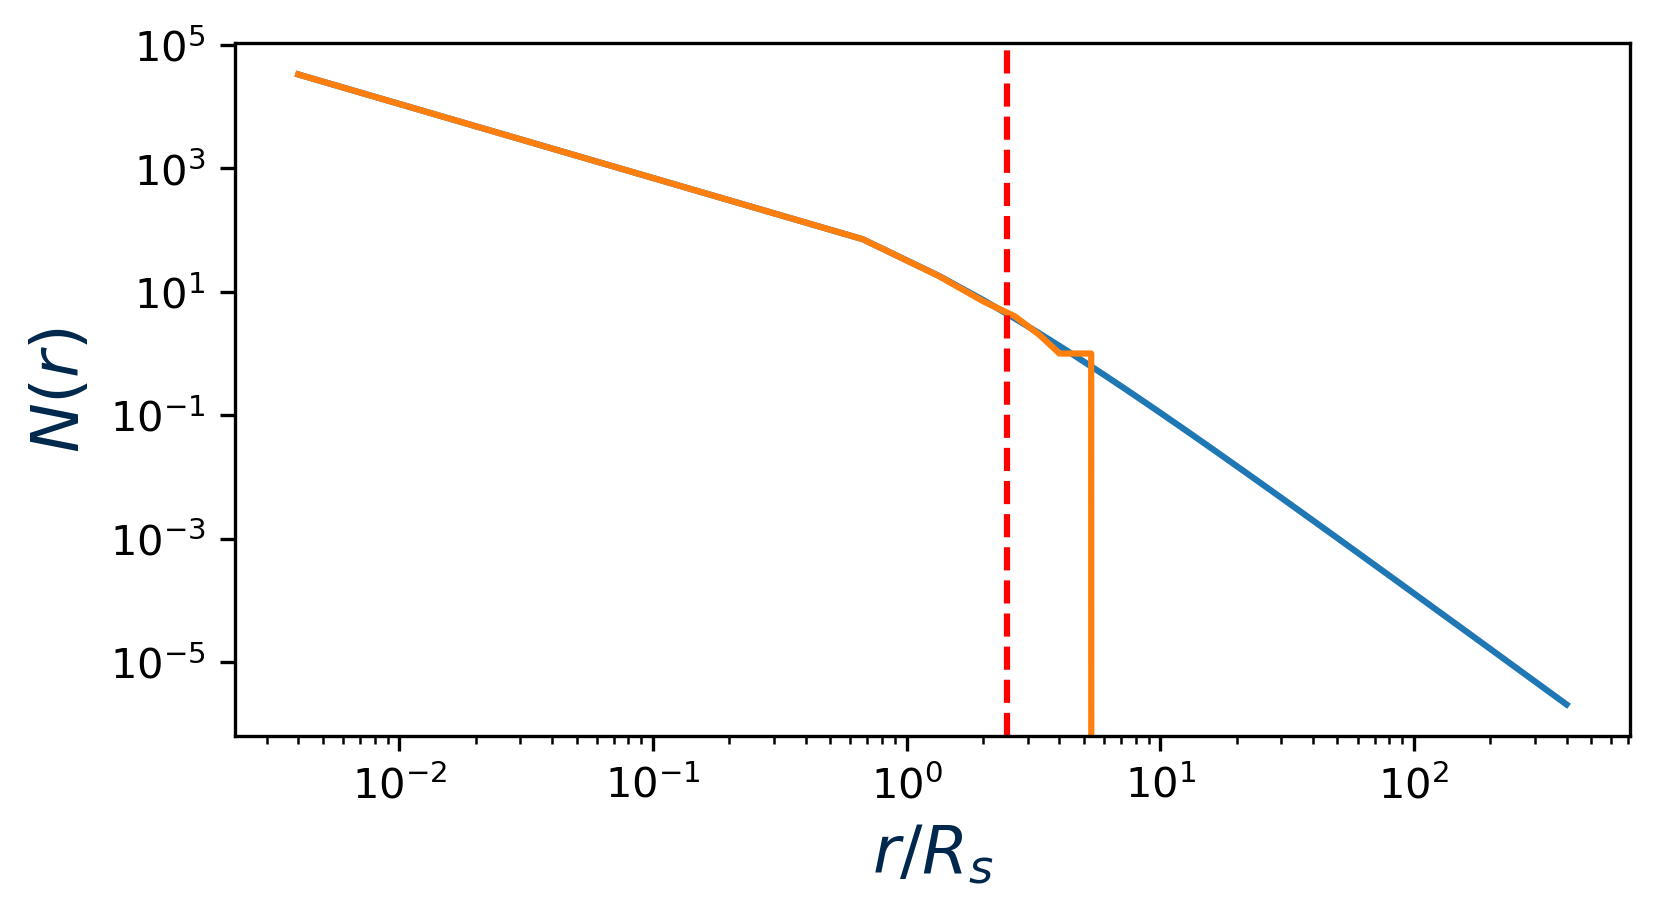

In [116]:
radius_range = np.linspace(0.01,1000,600)

plt.figure(figsize=(6,3), dpi=300)

plt.plot(radius_range/Rs, [NFW(r, Rs, n0) for r in radius_range])
plt.plot(radius_range/Rs, [NFW_round(r, Rs, n0) for r in radius_range])
plt.axvline(x = Rs, color="red", ls = "--")

plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"$r/R_s$", fontdict=font)
plt.ylabel(r"$N(r)$", fontdict=font)

To simplify, we calculate the mean number density within the critical radius and the mean number density between the critical radius and cut-off radius (where rounded N(r) is 0). 

In [117]:
# Total number of DM particles in the inner and outer region, 
# 15 is divided because otherwise it takes too long for computer to calculate
N_inner = round(romberg(NFW, 0.1, Rs, args=(Rs, n0))/15)
N_outer = round(romberg(NFW, Rs, 5*Rs, args=(Rs, n0))/15)
[N_inner, N_outer]

[47, 4]

Now the estimation is complete, lets try visualize this halo in 3D. I allow schocastic halo distirbution in each region.

In [118]:
R_inner = np.random.rand(N_inner)*Rs
Theta_inner = np.random.rand(N_inner)*np.pi
Phi_inner = np.random.rand(N_inner)*np.pi*2

R_outer = np.random.rand(N_inner)*Rs*3 + Rs
Theta_outer = np.random.rand(N_inner)*np.pi
Phi_outer = np.random.rand(N_inner)*np.pi*2

R_Arr = np.concatenate((R_inner, R_outer))
Theta_Arr = np.concatenate((Theta_inner, Theta_outer))
Phi_Arr = np.concatenate((Phi_inner, Phi_outer))


In [119]:
# Coordinate of points in the halo
X = R_Arr*np.sin(Theta_Arr)*np.cos(Phi_Arr)
Y = R_Arr*np.sin(Theta_Arr)*np.sin(Phi_Arr)
Z = R_Arr*np.cos(Theta_Arr)

In [120]:
P = np.array([[X[i],Y[i],Z[i]] for i in range(0,len(X))])

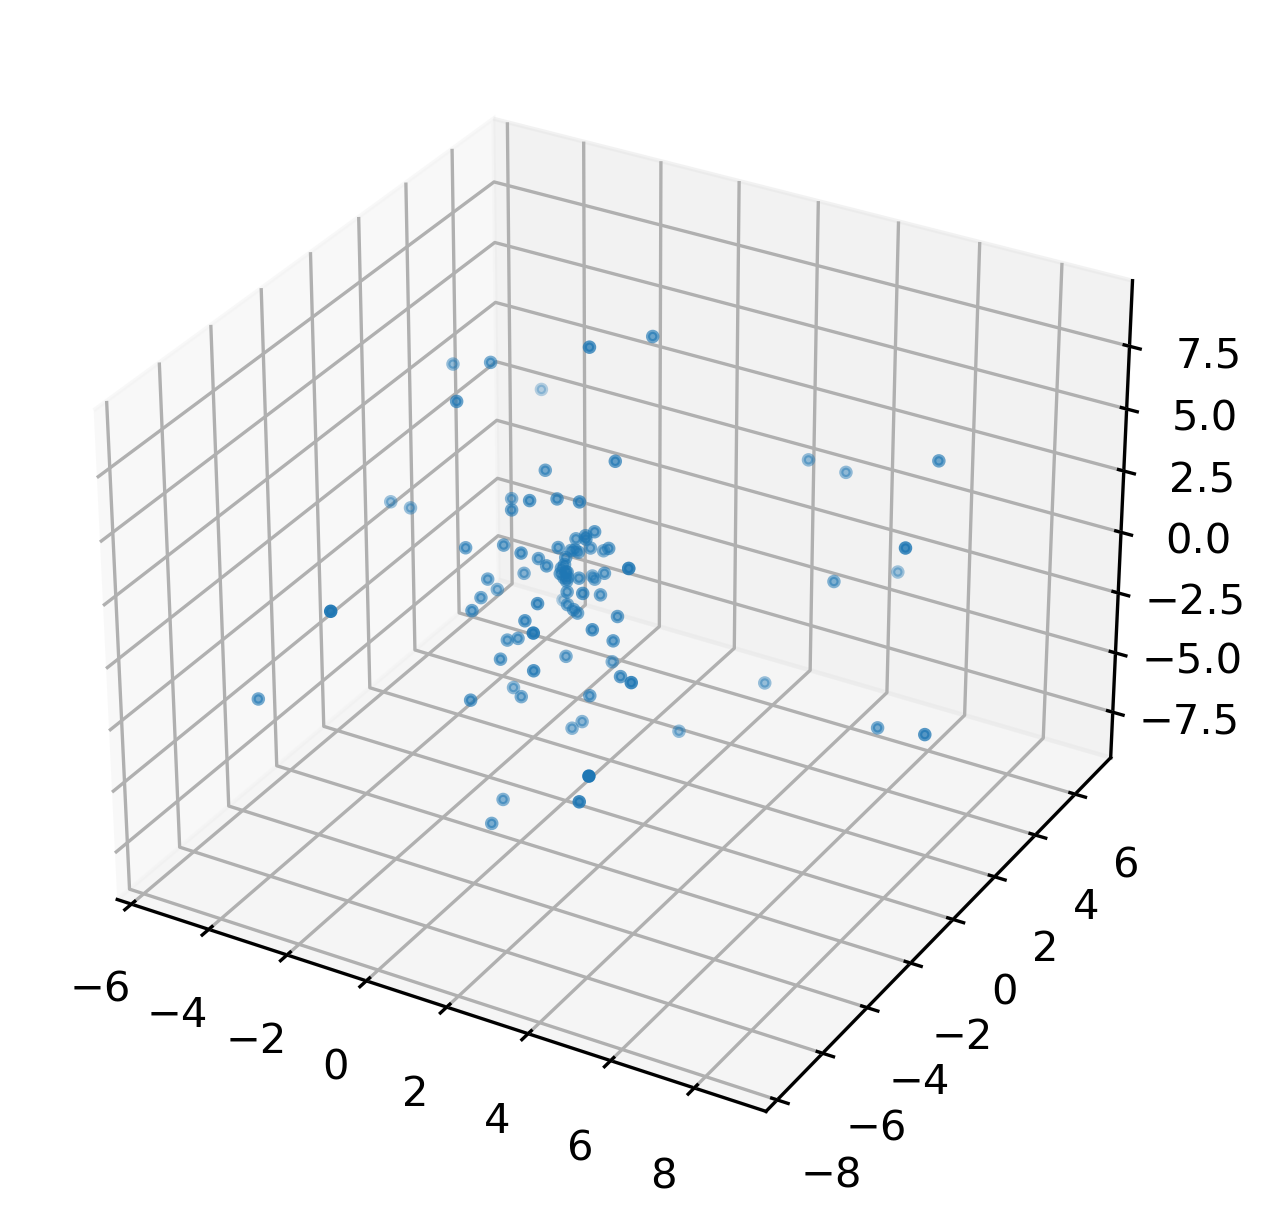

In [121]:
ax = plt.figure(figsize=(5,5), dpi=300).add_subplot(projection='3d')
ax.scatter(X,Y,Z, marker=".")
plt.savefig(DIR + "/2Halo_Simulations/images/halo.png")

# 4th Order Runge-Kutta Method

We have finished modelling the halo using the codes above, let us start the simulation.

In [122]:

def get_acceleration(positions):
    """
    Compute the acceleration of each particle given their positions.

    Args:
    - positions: N x 3 array that contains information of particle positions in cartesian coordinate

    Variables:
    - G: Gravitational Constant
    - M: Mass of the other halo
    - m0: Mass of dark matter particles in a approximated halo

    Returns:
    - a:  N x 3 array that contains information of particle accelerations in cartesian coordinate
    """
    # Initialize acceleration to zero for each particle
    a = np.zeros_like(positions)

    # Loop over all particle pairs
    for i in range(len(positions)):
        for j in range(len(positions)):
            if i == j:
                continue
            
            # Compute the distance and direction vector between the particles
            r = positions[j] - positions[i]
            r_norm = np.linalg.norm(r) + 1
            # 1 is added to avoid sudden acceleration caused by inappropriate time step and distances that is too small
            r_dir = r / r_norm

            # The acceleration from the other halo
            if j == len(positions) - 1:
                a[i] += G * M * r_dir / r_norm**2
            else:
            # Add the gravitational acceleration to the particle's acceleration
                a[i] += G * m0 * r_dir / r_norm**2

    return a


In [123]:
def runge_kutta(positions, velocities, dt):
    """
    Compute the next positions and velocities using the fourth-order Runge-Kutta method.
    """
    # Compute the acceleration at the current positions
    a1 = get_acceleration(positions)

    # Compute the velocities at the half time step
    v_half = velocities + 0.5 * dt * a1

    # Compute the positions at the half time step
    x_half = positions + 0.5 * dt * v_half

    # Compute the acceleration at the half time step
    a2 = get_acceleration(x_half)

    # Compute the velocities at the next time step
    v_next = velocities + dt * a2

    # Compute the positions at the next time step
    x_next = positions + dt * v_half

    return x_next, v_next

In [124]:
# Initial position of the other halo approximated as a point mass
rM = np.array([[0,0,0]])
vM = np.array([[0, 0, 0]])
# Initial mass of the other halo
M = len(X) * m0 

In [125]:
# Initialize the positions and velocities of the dark matter particles in the halo
r = np.array([X, Y, Z]).T - 3
v = np.zeros_like(r) + 0.3


r = np.concatenate((r,rM))
v = np.concatenate((v,vM))

In [126]:
G = 8.5
dt = 0.04
t = 0 
i = 0
while True:
    # Compute the next positions and velocities
    r, v = runge_kutta(r, v, dt)

    plt.figure(figsize=(4,4), dpi=72)
    plt.scatter(r.T[0][:-1], r.T[1][:-1], marker=".", s=4, color = "#00274C", alpha=0.6)
    plt.scatter(r.T[0][-1], r.T[1][-1], marker="o", s=200, alpha=0.4, color = "#FFCB05")
    plt.xlabel("x", fontdict=font)
    plt.ylabel("y", fontdict=font)
    plt.xlim(-15,15)
    plt.ylim(-15,15)
    plt.savefig(DIR + "/2Halo_Simulations/images/test/test%i.png" % i)
    plt.close()

    
    # Update the time step
    t += dt
    i += 1

    # Check for convergence or maximum time
    if  i > 1200:
        break

In [1]:
import numpy as np

In [5]:
DM_r_relative = np.random.rand(300, 3) * 40
v = np.random.rand(300, 3) * 15

In [21]:
binsize = (np.max(DM_r_relative, axis=0) - np.min(DM_r_relative, axis=0)) / np.array([15, 15, 15])
mask_ind = np.all((DM_r_relative >= np.zeros(3)) & (DM_r_relative < binsize), axis=1)

In [22]:
mask_ind 

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,